In [2]:
import sys
sys.path.insert(1, '../')
from readntuple import *

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ATLAS)

import awkward as ak
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


import tensorflow as tf
from tensorflow.keras import layers, models, Model

2024-06-06 11:02:46.556589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-06 11:02:46.556830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [64]:
cuts = "(nBTags==6) & (isSR==1)"
#cuts = None

sig1 = readntuple_pre("/nfs/dust/atlas/user/gonzalem/TripleHiggs/PreProcessingFiles/K3K4_ValPoints_537274",
                   samplename="sig1",
                   cuts=cuts)
sig1['label'] = [0] * len(sig1)
print("Finished sig1")

sig2 = readntuple_pre("/nfs/dust/atlas/user/gonzalem/TripleHiggs/PreProcessingFiles/K3K4_ValPoints_537276",
                   samplename="sig2",
                   cuts=cuts)
sig2['label'] = [1] * len(sig2)
print("Finished sig2")

table = ak.concatenate([sig1, sig2])
print("Finished concatenation")

Finished sig1
Finished sig2
Finished concatenation


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2b15c5d699a0>, errorbar=None, legend_artist=None)]

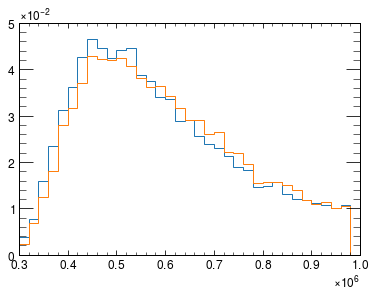

In [57]:
bins=np.arange(300, 1000, 20) * 1e3
hep.histplot( np.histogram(sig1['mHHH'].to_list(), bins=bins, weights=sig1['normalisedWeight'].to_list()) )
hep.histplot( np.histogram(sig2['mHHH'].to_list(), bins=bins, weights=sig2['normalisedWeight'].to_list()) )

In [61]:
def ScaleTransformArrayOfArrays(array, isjets):
    
    if isjets:
        flat_array = [jet for event in array for jet in event]
        flat_array = np.array(flat_array)
    else:
        flat_array = np.copy(array)
        
    # Initialize the StandardScaler
    scalers = [StandardScaler() for _ in range(flat_array.shape[1])]

    # Apply the StandardScaler to each kinematic variable
    __scaled_array = np.array([
        scalers[i].fit_transform(flat_array[:, i].reshape(-1, 1)).flatten()
        for i in range(flat_array.shape[1])
    ]).T

    if isjets:
        # Reconstruct the jets with the scaled kinematic variables
        scaled_array = []
        start = 0
        for event in array:
            num_lists = len(event)
            scaled_array.append(__scaled_array[start:start + num_lists].tolist())
            start += num_lists

        return scaled_array
    else:
        return __scaled_array

def PadJets(array, max_jets=20):
    _max_jets = 20
    # We pad events with dummy jets so each event has the same number of jets
    _padded_jets = np.array([np.pad(event, ((0, max_jets - len(event)), (0, 0)), 'constant') for event in array])
    # We create a mask to know which of the jets are not dummy and should be used
    _mask = np.array([[True] * len(event) + [False] * (max_jets - len(event)) for event in array])

    return _padded_jets, _mask
    
def GetModelInput(array, return_label=True):
    """
        Getting jets as list of lists
        jets = [ [jet_1, jet_2], #event1
                 [jet_1],  #event2
                 ...] ...
                where jet_i is a list [E,pt,phi,eta]
    
        We also get some global variables as a list of lists
        global_vars = [ [var1, var2, var3, ..., varN], #event1
                        [var1, var2, var3, ..., varN], #event2
                        ....] ...
                 where vari is always a float
    """
 
    
    _jets = ak.zip({"E": array["jets_E"], "pt": array["jets_pt"], "phi": array["jets_phi"], "eta": array["jets_eta"]})
    _jets = ak.to_list(_jets)
    _jets = [[[jet['E'], jet['pt'], jet['phi'], jet['eta']] for jet in jets_event] for jets_event in _jets]
    
    _global_vars = np.array( [(array['mH1'] / 1e3).to_list(),
                             (array['mH2'] / 1e3).to_list(),
                             (array['mH3'] / 1e3).to_list(),
                             (array['mHHH'] / 1e3).to_list()] ).T
      
    _weights = np.array( array['normalisedWeight'].to_list() ) 
    if return_label:
        _labels =  np.array( array['label'].to_list() ) 
    else:
        _labels = None
    return _jets, _global_vars, _weights, _labels

In [62]:
class TransformerClassifier(Model):
    def __init__(self, d=256, h=4, n_embed=2, n_attblock=10, n_dense=4, d_global_nn=None):
        super().__init__()
        
        self.d = d
        self.h = h
        self.n_embed = n_embed
        self.n_attblock = n_attblock
        self.n_dense = n_dense
        self.d_global_nn = d_global_nn if d_global_nn is not None else self.d
        
        # Create multiple embedding layers
        self.embedding_layers = [
            layers.Dense(self.d, activation='relu', name=f'jet_embedding_{i+1}')
            for i in range(n_embed)
        ]
        
        # Apply layer normalization to the final embedding layer's output
        self.first_layerNormalisation = layers.LayerNormalization(name='layer_normalization_global_1')
        
        # Multiple attention blocks
        self.attentions, self.linear_layers, self.layer_normalisations1, self.layer_normalisations2 = [], [], [], []
        for block in range(self.n_attblock):
            
            # Multi-Headed Self-Attention block
            self.attentions.append(
                layers.MultiHeadAttention(num_heads=self.h, key_dim=self.d, name=f'multi_head_attention_{block+1}')
            )
            
            # Apply LayerNormalization
            self.layer_normalisations1.append(
                layers.LayerNormalization(name=f'layer_normalization_block{block+1}_1')
            )
            
            # Add multiple linear (Dense) layers, the last one without activation
            self.linear_layers.append([])
            for i in range(self.n_dense):
                activation='relu' if i < n_dense-1 else None
                self.linear_layers[block].append(
                    layers.Dense(self.d, activation=activation, name=f'linear_layer_block{block+1}_{i+1}')
                )
            
            # Apply final LayerNormalization
            self.layer_normalisations2.append(
                layers.LayerNormalization(name=f'layer_normalization_block{block+1}_2')
            )
        
        # Cross-Attention Pooling with 1 output node to convert shapes.
        self.pooling = layers.Dense(1, activation='relu', use_bias=False, name='cross_attention_pooling')

        # Final classification layer
        self.classification = layers.Dense(1, activation='sigmoid', name='classification')
        
        ### Additional NN for the global variables
        self.global_nn = layers.Dense(self.d_global_nn, activation='relu', name='linear_layer_globalnn')
        
    def call(self, inputs):
        jets_input, mask = inputs
        
        x = jets_input
        #multiple embedding layers
        for i in range(self.n_embed):
            x = self.embedding_layers[i](x)
        
        # Apply layer normalization to the final embedding layer's output
        x = self.first_layerNormalisation(x)
        
        # Multiple attention blocks
        for block in range(self.n_attblock):
            
            # Multi-Headed Self-Attention block
            attn = self.attentions[block](x, x, attention_mask=mask)
        
            # Apply LayerNormalization
            x = self.layer_normalisations1[block](attn+x)
            # Add multiple linear (Dense) layers, the last one without activation
            ffn = x
            for i in range(self.n_dense):
                ffn = self.linear_layers[block][i](ffn)
        
            # Apply final LayerNormalization
            x = self.layer_normalisations2[block](ffn+x)
        
        # Cross-Attention Pooling
        pooling = self.pooling(x)
        x = tf.reduce_sum((pooling * x), axis=1)
        
        #Use the global variables and concatenate with results from jets
        #globalout = self.global_nn(global_vars)
        #combined_output = tf.concat([x, globalout], axis=1)
        
        #Make classification   #use combined_output if including global variables
        logits = self.classification(x)
        
        return logits

In [66]:
jets, global_vars, weights, labels = GetModelInput(table)
jets = ScaleTransformArrayOfArrays(jets, isjets=True)
global_vars = ScaleTransformArrayOfArrays(global_vars, isjets=False)
jets, mask = PadJets(jets)

jets, mask, global_vars, weights, labels = shuffle(jets, mask, global_vars, weights, labels)
jets = tf.convert_to_tensor(jets, dtype=tf.float64)
mask = tf.convert_to_tensor(mask[:, tf.newaxis, tf.newaxis, :], dtype=tf.int32) #otherwise doesn't work for batch_size>1

In [68]:
if len(table) != len(labels):
    raise ValueError("Make sure you re-ran the last cell")

model = TransformerClassifier(d=16, h=4, n_embed=1, n_attblock=3, n_dense=1)
loss = 'binary_crossentropy'
model.compile(optimizer='adam', loss=loss, 
              metrics=['accuracy'], weighted_metrics=['accuracy'])

history = model.fit((jets, mask), labels, epochs=10, batch_size=32, 
                    sample_weight=weights, validation_split=0.15)

Epoch 1/10
60/60 [==============================] - 4s 33ms/step - loss: 7.5857e-04 - accuracy: 0.5107 - weighted_accuracy: 0.4988 - val_loss: 6.2393e-04 - val_accuracy: 0.5310 - val_weighted_accuracy: 0.5112
Epoch 2/10
60/60 [==============================] - 1s 20ms/step - loss: 6.1303e-04 - accuracy: 0.5133 - weighted_accuracy: 0.4982 - val_loss: 6.2434e-04 - val_accuracy: 0.5280 - val_weighted_accuracy: 0.5076
Epoch 3/10
60/60 [==============================] - 1s 23ms/step - loss: 6.1276e-04 - accuracy: 0.5138 - weighted_accuracy: 0.4986 - val_loss: 6.2439e-04 - val_accuracy: 0.5280 - val_weighted_accuracy: 0.5076
Epoch 4/10
60/60 [==============================] - 1s 23ms/step - loss: 6.1286e-04 - accuracy: 0.5138 - weighted_accuracy: 0.4986 - val_loss: 6.2423e-04 - val_accuracy: 0.5280 - val_weighted_accuracy: 0.5076
Epoch 5/10
60/60 [==============================] - 1s 22ms/step - loss: 6.1278e-04 - accuracy: 0.5138 - weighted_accuracy: 0.4986 - val_loss: 6.2423e-04 - val_accu

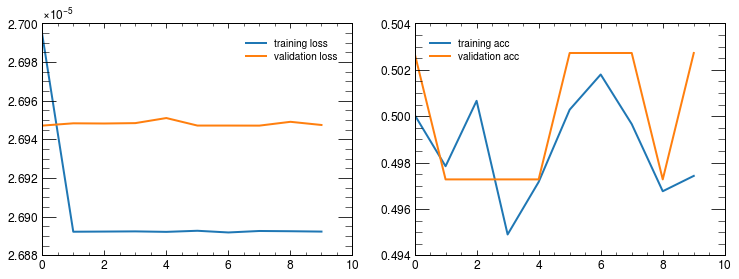

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].plot(history.epoch, history.history['loss'], label='training loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='validation loss')
ax[0].legend()

ax[1].plot(history.epoch, history.history['weighted_accuracy'], label='training acc')
ax[1].plot(history.epoch, history.history['val_weighted_accuracy'], label='validation acc')
ax[1].legend()